In [1]:
# Useful functions to use:
# skimage.draw.line_nd
# numpy.convolve
# jpg i dicom
#TODO przetwarzanie obrazu stożkowo, 90-270 na 4    50%
#TODO 90-720 x, miary zgodności y
#TODO filtrowanie

In [2]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt

In [3]:
def loadImage(filename):
    image = ski.io.imread(filename)
    image = ski.color.rgb2gray(image)
    image /= np.max(image)
    return image

def saveImage(image, filename):
    data = (image * 255).astype(np.uint8)
    ski.io.imsave(filename, data)

def showImage(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [ ]:
REFERENCE_DICOM = 'dicom/Kolo.dcm'
image = loadImage("images/CT_ScoutView.jpg")

In [4]:
import pydicom

# Use this file as a wireframe while constructing a new DICOM file
def loadDicom(filename):
    ds = pydicom.dcmread(filename)
    imageData = ds.pixel_array
    image = imageData / np.max(imageData)

    patName = ds.PatientName
    displayName = patName.given_name + " " + patName.family_name
    comment = ds.ImageComments
    acquisitionDate = ds.get('AcquisitionDate', None)

    metadata = (displayName, comment, acquisitionDate)
    return image, metadata

def saveDicom(filename, image, metadata):
    imageData = (image * 255).astype(np.uint8)

    ds = pydicom.dcmread(REFERENCE_DICOM)
    ds.PixelData = imageData.tobytes()
    ds.Rows, ds.Columns = imageData.shape

    patName = metadata[0].split(' ', maxsplit=1)
    ds.PatientName = patName[1] + '^' + patName[0]
    ds.ImageComments = metadata[1]
    ds.AcquisitionDate = metadata[2]
    ds.save_as(filename, write_like_original=False)


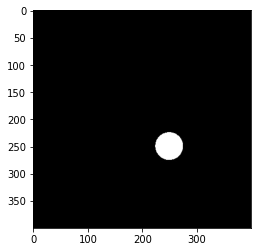

In [5]:
image = loadImage('images/Kropka.jpg')
showImage(image)

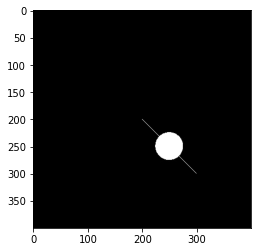

In [6]:
l = ski.draw.line_nd((200, 200), (300, 300))
image[l] = 1
showImage(image)
saveImage(image, 'Kropka.png')

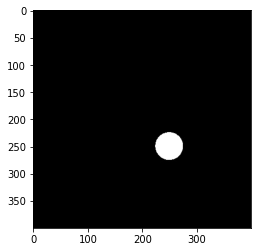

('John Doe', 'what a lovely image we have here...', None)


In [7]:
dicomImage, metadata = loadDicom('dicom/Kropka.dcm')
showImage(dicomImage)
print(metadata)

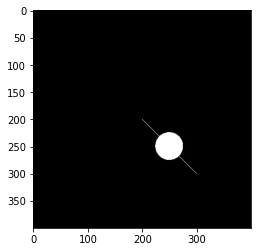

In [8]:
l = ski.draw.line_nd((200, 200), (300, 300))
dicomImage[l] = 1
showImage(dicomImage)
saveDicom('Kropka.dcm', dicomImage, (metadata[0], 'Kropka', '20230304'))

# Radon transform
### Performs a Radon transform on an image
- image: 2D array (floats in range [0, 1])
- detectors: number of detectors (equally spaced on an arc)
- scans: number of samples to take (emitter positions equally spaced around the circle)
- detectingAngle: angle of the arc (in degrees) with detectors

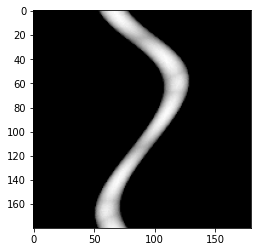

In [9]:
def radonTransform(image, detectors = 180, scans = 180, detectingAngle = 180):
	center = np.array(image.shape) // 2     # Center of the emitter-detector system
	radius = np.sqrt(2) * max(center)       # Radius of the round frame (half-diagonal of the image)
	radonImage = np.zeros((scans, detectors), dtype=image.dtype)
	phi = np.deg2rad(detectingAngle)        # Span of the detectors arc
	
	# Where to place the emitter in subsequent scans
	scanAngles = np.linspace(0, 2 * np.pi, scans, endpoint=False)

	detectorAngleGap = phi / (detectors - 1)
	for i, angle in enumerate(scanAngles):
		
		E = np.array([np.cos(angle), np.sin(angle)]) * radius + center
		for j in range(detectors):
			# Where to place the j-th detector
			detectorAngle = angle + np.pi - phi / 2 + j * detectorAngleGap
			D = np.array([np.cos(detectorAngle), np.sin(detectorAngle)]) * radius + center

			# Make a line between the emitter and the detector
			# And ensure it is in bounds of the image
			y, x = ski.draw.line_nd(E, D)
			inBounds = (0 <= x) & (x < image.shape[1]) & (0 <= y) & (y < image.shape[0])
			line = (y[inBounds], x[inBounds])
			# Average the values of the image along the line
			radonImage[i, j] = np.average(image[line])
	return radonImage

image = loadImage('images/Kropka.jpg')
radonImage = radonTransform(image)
showImage(radonImage)

# Sinogram filtering
### Function to filter image with different filters
- image - image to filter
- lib - library to use (opencv or numpy)
- returns filtered image


In [15]:
import cv2

def filtering(image, lib='numpy'):
	if (lib == 'opencv'):
		kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
		img = cv2.filter2D(image, -1, kernel)
		return img
	else:
		kernel = np.zeros(21)
		kernel[10] = 1
		for i in range(11, 21, 2):
			kernel[i] = -4/np.pi**2/(i-10)**2 
		kernel[:10] = kernel[11:][::-1]
		plt.plot(kernel)
		for iteration, i in enumerate(image):
			image[iteration] = np.convolve(i, kernel, mode='same')
		return image

# Inverse Radon transform

### Do an inverse Radon transform using sinogram
- image: 2D array (floats in range [0, 1])
- shape: shape of an Radon image
- detectingAngle: angle of the arc (in degrees) with detectors

In [11]:
def inverseRadonTransform(image, shape, detectingAngle = 180):
    scans = image.shape[0]
    detectors = image.shape[1]
    center = np.array(shape) // 2     		# Center of the emitter-detector system
    radius = np.sqrt(2) * max(center)       # Radius of the round frame (half-diagonal of the image)
    invRadonImage = np.zeros(shape, dtype=image.dtype)
    phi = np.deg2rad(detectingAngle)        # Span of the detectors arc

    # Where to place the emitter in subsequent scans
    scanAngles = np.linspace(0, 2 * np.pi, scans, endpoint=False)
    detectorAngleGap = phi / (detectors - 1)
    for i, angle in enumerate(scanAngles):
        E = np.array([np.cos(angle), np.sin(angle)]) * radius + center

        for j in range(detectors):
            # Where to place the j-th detector
            detectorAngle = angle + np.pi - phi / 2 + j * detectorAngleGap
            D = np.array([np.cos(detectorAngle), np.sin(detectorAngle)]) * radius + center

            # Make a line between the emitter and the detector
            # And ensure it is in bounds of the image
            y, x = ski.draw.line_nd(E, D)
            inBounds = (0 <= x) & (x < shape[1]) & (0 <= y) & (y < shape[0])
            line = (y[inBounds], x[inBounds])

            # Average the values of the image along the line
            invRadonImage[line] += image[i, j]
    return invRadonImage

# Radon transform and inverse Radon transform with and without filtering using opencv and numpy convolution

In [16]:
imageName = 'images/CT_ScoutView.jpg'
print("before")
image = loadImage(imageName)
showImage(image)

print("sinogram")
radonImage = radonTransform(image)
showImage(radonImage)

print("reult without filtering")
invRadonTransform = inverseRadonTransform(radonImage, image.shape)
showImage(invRadonTransform)

print("filtering using opencv")
radonImageOpenCV = filtering(radonImage, 'opencv')
showImage(radonImageOpenCV)

print("filtering using numpy convolution")
radonImageConv = filtering(radonImage, 'convlution')
showImage(radonImageConv)

print("result openCV")
invRadonTransform = inverseRadonTransform(radonImageOpenCV, image.shape)
showImage(invRadonTransform)

print("result convolution")
invRadonTransform = inverseRadonTransform(radonImageConv, image.shape)
showImage(invRadonTransform)

before


ValueError: the input array must have size 3 along `channel_axis`, got (1024, 880)

# Save and read pydicom file

C:\Users\Helena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pydicom\valuerep.py:290: UserWarning: Invalid value for VR DA: '2005-05-06'.
  warnings.warn(msg)


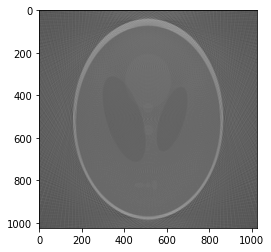

Patient's name: 	Jan Kowalski
Patient's ID: 		47783567359
Patient's birth date: 	2005-05-06
Image comments: 	Everything ok


In [ ]:
import os
type(invRadonTransform)
# save as dicom
filePathDicom = os.path.splitext(imageName)[0] + '_modified.dcm'

from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity

def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img_converted = convert_image_to_ubyte(img)
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    ds.PatientBirthDate = patient_data["PatientBirthDate"]
    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7
    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape
    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)
    ds.PixelData = img_converted.tobytes()
    ds.save_as(file_name, write_like_original=False)
    
save_as_dicom(filePathDicom, invRadonTransform, {"PatientName": "Jan Kowalski", 
                                                 "ImageComments": "Everything ok", 
                                                 "PatientID": "47783567359", 
                                                 "PatientBirthDate": "2005-05-06"})
dicomImage, _ = loadDicom(filePathDicom)
ds = pydicom.filereader.dcmread(filePathDicom)
showImage(dicomImage)
print("Patient's name: \t" + str(ds.PatientName))
print("Patient's ID: \t\t" + ds.PatientID)
print("Patient's birth date: \t" + ds.PatientBirthDate)
print("Image comments: \t" + ds.ImageComments)
#print(ds)

Our try to solve problems

In [ ]:
import math

#coords = np.array(image.shape[0], image.shape[1]) #1-400 array
#x, y = image.shape[0], image.shape[1]
def nk():
	n = 90 							# not sure
	r = 200 						# not sure
	plot = [[],[]]
	for alpha in range(90, 181):
		radiansAlpha = math.radians(alpha)
		xE = r * math.cos(radiansAlpha)
		yE = r * math.sin(radiansAlpha)
		for i in range(n):
			fi = 90/n  				# not sure
			xD = r * math.cos(radiansAlpha + math.pi + fi/2 + i*fi/(n-1))
			yD = r * math.sin(radiansAlpha + math.pi + fi/2 + i*fi/(n-1))
		plot[0].append(xE)
		plot[1].append(yE)
	plt.plot(plot, color="gray")
	plt.show()
print(plot)
showImage(plot)


NameError: name 'plot' is not defined